### This notebook describes the TE variation analysis of DK0911

This notebook and analysis is based on a discussion with Cecile Lorrain and on the following paper https://www.nature.com/articles/ncomms5104.  
The idea here was to see what the TE variation profile is in DK0911 and Pst104E. Does is varry or is it the same. In addition I addressed the question of when the TE size difference occured in Pst104E vs DK0911.

#### TE analysis in regards to conservation and age

In [1]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt
import json
from ipywidgets import widgets
from IPython.display import display
from sklearn.externals.joblib import Parallel, delayed
import seaborn as sns
import matplotlib
import subprocess

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [2]:
def get_TE_diversity_df(genome_repet, TE_postanalysis_dir):
    """Get the combined repet TE dataframe with proper annotation."""
    TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      \
    minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')
    TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']
    #now get the summary of allTEs == TEs specificaly identified by TEdenovo from REPET
    REPET_denovoTEs_df = pd.read_csv(\
            os.path.join(TE_postanalysis_dir, '%s_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' % genome_repet),\
                                    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

    #now get in the summary of all bankBLRx TEs == TEs identified by repbase20.05_ntSeq_cleaned_TE
    REPET_nt_repbase_df = pd.read_csv(\
        os.path.join(TE_postanalysis_dir, '%s_chr_bankBLRx_path.annotStatsPerTE.tab' % genome_repet) ,\
        names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

    #now get in the summary of all bankBLRtx TEs == TEs identified by repbase20.05_aaSeq_cleaned_TE
    REPET_aa_repbase_df = pd.read_csv(\
        os.path.join(TE_postanalysis_dir, '%s_chr_bankBLRtx_path.annotStatsPerTE.tab' % genome_repet) ,\
        names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )
    #generate a df that contains all TEs: TEdenovo, blastx, blastn
    REPET_all_TEs_df = pd.concat([REPET_denovoTEs_df ,REPET_nt_repbase_df,\
                                       REPET_aa_repbase_df], axis=0)
    REPET_all_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.copies > 0]
    REPET_all_TEs_df = REPET_all_TEs_df[~REPET_all_TEs_df.TE.str.startswith("Potential")]
    intervals = pd.interval_range(start=20, end=100, closed='right', periods=100)
    REPET_all_TEs_df['Intervals'] = pd.cut(REPET_all_TEs_df.meanId, intervals)

    grouped = REPET_all_TEs_df.groupby('Intervals')
    sum_df = grouped.agg({'meanId': 'mean', 'covg': 'sum'})
    sum_df['Interval_edge'] = intervals.right
    sum_df['freq_covg'] = sum_df.covg / sum_df.covg.sum()
    sum_df["re_cumsum_covg"] = sum_df.sort_values('Interval_edge', ascending='False')['covg'].cumsum()
    return REPET_all_TEs_df, sum_df

In [3]:
#define all the path variables, keys, and such
genomes = ["APSI_primary_v1"]
repet_genomes = [ 'MR_P2_a0']
genome_folder = '../../genome'
repet_post_dir = {}
repet_post_dir['APSI_primary_v1'] = '../../../genome_v03/REPET/TEannot/primary'

sum_df_dict = {}
REPET_all_TEs_df_dict ={}


In [4]:
##OUTPATH for figures
OUTPATH='../../TE_analysis/'

In [5]:
for genome, r_genome in zip(genomes, repet_genomes):
    print(genome, r_genome)
    REPET_all_TEs_df_dict[genome] ,sum_df_dict[genome] = get_TE_diversity_df(r_genome, repet_post_dir[genome])

APSI_primary_v1 MR_P2_a0


In [6]:
from scipy.interpolate import interp1d
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 14}

matplotlib.rc('font', **font)

In [7]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

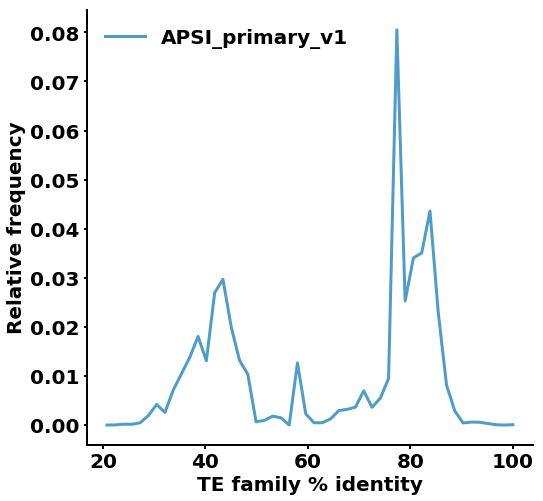

In [8]:
f, ax = plt.subplots(figsize=(8,8))
pallete = [sns.color_palette('colorblind')[x] for x in [0,1]]
for genome, color in zip(genomes, pallete):
    x, y = sum_df_dict[genome]['Interval_edge'], sum_df_dict[genome]['freq_covg']
    f2 = interp1d(x, y)
    xnew = np.linspace(x.min(), x.max(), num=50, endpoint=True)
    ax.plot(xnew, f2(xnew), '-', color=color, label = genome,  linewidth=3, alpha = 0.7)
ax.legend()
ax.set_ylabel('Relative frequency', **font)
ax.set_xlabel('TE family % identity', **font)
outfn = os.path.join(OUTPATH, 'SF2A_TE_variation.tiff')
plt.legend(loc='upper left', frameon=False)
#['top','bottom','left','right']
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)

#plt.savefig(outfn, dpi=600,bbox_inches='tight')

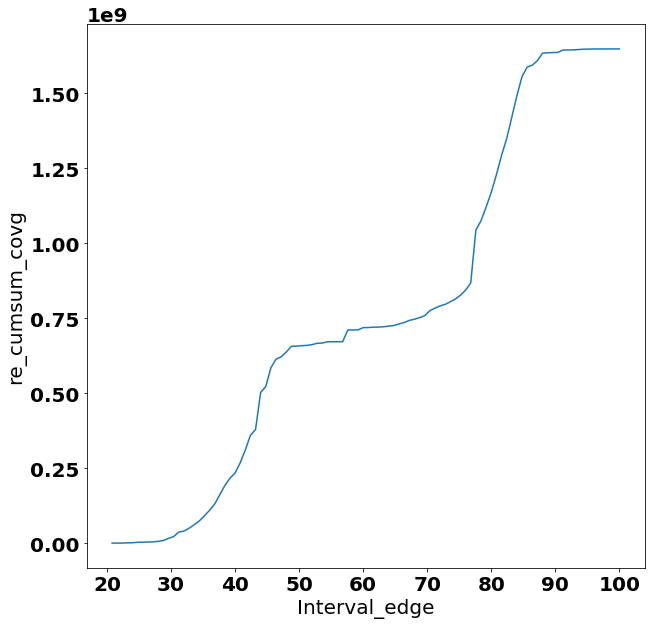

In [9]:
f, ax = plt.subplots(figsize=(10,10))
for genome in genomes:
    sns.lineplot(sum_df_dict[genome]['Interval_edge'], sum_df_dict[genome]["re_cumsum_covg"], ax=ax)

In [10]:
TE_df = REPET_all_TEs_df_dict[genome]

In [11]:
TE_df.columns

Index(['TE', 'length', 'covg', 'frags', 'fullLgthFrags', 'copies',
       'fullLgthCopies', 'meanId', 'sdId', 'minId', 'q25Id', 'medId', 'q75Id',
       'maxId', 'meanLgth', 'sdLgth', 'minLgth', 'q25Lgth', 'medLgth',
       'q75Lgth', 'maxLgth', 'meanLgthPerc', 'sdLgthPerc', 'minLgthPerc',
       'q25LgthPerc', 'medLgthPerc', 'q75LgthPerc', 'maxLgthPerc',
       'Intervals'],
      dtype='object')

In [12]:
TE_df.sort_values(['meanId'], ascending=False)

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,q75Lgth,maxLgth,meanLgthPerc,sdLgthPerc,minLgthPerc,q25LgthPerc,medLgthPerc,q75LgthPerc,maxLgthPerc,Intervals
3268,RLX-incomp_Blc2961_MR_P2A_300Mb-L-B4036-Map1,8656,43,1,0,1,0,100.00,0.00,100.00,...,43.0,43.0,0.50,0.00,0.50,0.50,0.50,0.50,0.50,"(99.2, 100.0]"
4070,RLX-incomp_Blc4432_MR_P2A_300Mb-L-B5887-Map1,1800,1480,1,0,1,0,100.00,0.00,100.00,...,1480.0,1480.0,82.22,0.00,82.22,82.22,82.22,82.22,82.22,"(99.2, 100.0]"
1338,RLX-comp_Blc4146_MR_P2A_300Mb-L-B5564-Map1,4303,69,1,0,1,0,100.00,0.00,100.00,...,69.0,69.0,1.60,0.00,1.60,1.60,1.60,1.60,1.60,"(99.2, 100.0]"
8358,Coprina_Cc1:ClassI:PLE:Penelope,3033,107874,253,1,242,1,99.69,1.27,88.10,...,493.0,7476.0,14.77,22.07,1.78,4.06,7.52,16.25,246.49,"(99.2, 100.0]"
967,RLX-comp_Blc2499_MR_P2A_300Mb-L-B3298-Map1,8993,164,4,0,4,0,99.40,1.20,97.60,...,64.0,64.0,0.63,0.12,0.47,0.64,0.68,0.71,0.71,"(99.2, 100.0]"
410,RIX-incomp_Blc4538_MR_P2A_300Mb-B-P207.85-Map3,1058,2118,2,2,2,2,99.40,0.85,98.80,...,1060.0,1060.0,100.09,0.13,100.00,100.00,100.09,100.19,100.19,"(99.2, 100.0]"
1188,RLX-comp_Blc3439_MR_P2A_300Mb-L-B4729-Map1_rev...,7660,106,2,0,2,0,99.10,1.27,98.20,...,64.0,64.0,0.69,0.20,0.55,0.55,0.69,0.84,0.84,"(98.4, 99.2]"
4018,RLX-incomp_Blc4189_MR_P2A_300Mb-L-B5614-Map1,3638,584,3,0,3,0,98.70,0.26,98.50,...,236.0,236.0,5.35,1.17,4.15,4.15,5.42,6.49,6.49,"(98.4, 99.2]"
1100,RLX-comp_Blc2_MR_P2A_300Mb-L-B4763-Map1,7405,36,1,0,1,0,98.20,0.00,98.20,...,36.0,36.0,0.49,0.00,0.49,0.49,0.49,0.49,0.49,"(97.60000000000001, 98.4]"
1313,RLX-comp_Blc3_MR_P2A_300Mb-L-B3738-Map1,8797,334,6,0,6,0,98.08,2.05,95.40,...,60.0,63.0,0.63,0.10,0.44,0.64,0.66,0.68,0.72,"(97.60000000000001, 98.4]"


Follow on from the idea of RIP and AT rich regions.
First do some analysis on AT-content.

In [13]:
AT_analysis = '../../AT_analysis'
if not os.path.exists(AT_analysis):
    os.makedirs(AT_analysis)

In [14]:
#run Occultercut on the command line in the new folder for AT analysis /home/benjamin/anaconda3/OcculterCut_v1.1/
#/home/benjamin/anaconda3/OcculterCut_v1.1/OcculterCut -f ../genome/APSI_primary_v1.fa

In [15]:
#first make some windows 

In [16]:
!ls {AT_analysis}

APSI_primary_v1.w1.s200.AT.bed	     APSI_primary_v1.w5.s1.AT.bed
APSI_primary_v1.w1.s200.AT.circabed  APSI_primary_v1.w5.s1.AT.circabed
APSI_primary_v1.w1.s200.bed	     APSI_primary_v1.w5.s1.bed
APSI_primary_v1.w50.s10.AT.bed	     compositionGC.txt
APSI_primary_v1.w50.s10.AT.circabed  myGenome.txt
APSI_primary_v1.w50.s10.bed	     regions.gff3


In [17]:
#get genome files and bed window files
window_fn_dict = {}
window_bed_dict = {}
window_fn_dict['w50kb_s10kb'] = os.path.join(AT_analysis, '%s.w50.s10.bed' % genome)
window_fn_dict['w5kb_s1kb'] = os.path.join(AT_analysis, '%s.w5.s1.bed' % genome)
window_fn_dict['w1kb_s200'] = os.path.join(AT_analysis, '%s.w1.s200.bed' % genome)
genome_size_f_fn = os.path.join(genome_folder, '%s.genome_file' % genome)
contig_fn = os.path.join(genome_folder,'%s.fa' % genome )

In [20]:
!bedtools makewindows -g {genome_size_f_fn} -w 5000 -s 1000 > {window_fn_dict['w5kb_s1kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 1000 -s 200 > {window_fn_dict['w1kb_s200']}

In [21]:
#new make a bedtools window dataframe
for key, value in window_fn_dict.items() :
    window_bed_dict[key] = BedTool(value)

In [22]:
#now make an AT bed df dict and save it out
window_AT_dict = {}
for key, value in window_bed_dict.items():
    tmp_df = value.nucleotide_content(fi=contig_fn).to_dataframe().iloc[1:,[0,1,2, 3]]
    tmp_df.rename(columns={'name':'%AT'}, inplace=True)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.bed')
    tmp_df.to_csv(tmp_fn, header=None, sep='\t', index=None)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.circabed')
    tmp_df.to_csv(tmp_fn, sep='\t', index=None)
    window_AT_dict[key] = tmp_df
    tmp_df = ''

/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [32]:
gene_bed_fn = '../../effector_analysis/APSI_primary_v1.transcript.genes.bed'
repeat_bed_fn = '../../TE_analysis/APSI_primary_v1.MR_P2A_300Mb.REPET_fix.superfamily.bed'

In [48]:
def AT_content_df(bed_fn, contig_fn, intervals, merge=True):
    bed = BedTool(bed_fn)
    if merge == True:
        bed.sort().merge()
    #specify datatypes if possible
    tmp_fn = bed_fn.replace('.bed', '.AT.bed.tmp')
    dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:str, 4:str, 5:str, 6:float}
    bed.nucleotide_content(fi=contig_fn).saveas(tmp_fn)
    #bedtools nuc -fi {contig_fn} -bed {bed_fn} > {tmp_fn}
    
    if len(bed.to_dataframe().columns) == 6:
        dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:str, 4:str, 5:str, 6:float}
        df = pd.read_csv( tmp_fn, sep='\t',header=None,dtype=dtype_dict, usecols=[0,1,2,3,6], skiprows=1)
        df.rename(columns={6:'%AT'}, inplace=True)
    elif len(bed.to_dataframe().columns) == 3:
        dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:float}
        df = pd.read_csv( tmp_fn, sep='\t',header=None,dtype=dtype_dict, usecols=[0,1,2,3], skiprows=1)
        df.rename(columns={3:'%AT'}, inplace=True)
    df['%AT'] = df['%AT'].astype('float')
    df['Intervals'] = pd.cut(df['%AT'], intervals)
    grouped = df.groupby('Intervals')
    sum_df = grouped.agg({'%AT': 'count'})
    sum_df['Interval_edge'] = intervals.right
    sum_df.fillna(0, inplace=True)
    sum_df['norm_count_AT'] = sum_df['%AT']/sum_df['%AT'].sum()
    os.remove(tmp_fn)
    return df, sum_df

In [34]:
intervals = pd.interval_range(start=0.2, end=1.0, closed='right', periods=80)
gene_at_df, gene_at_sum_df = AT_content_df(gene_bed_fn, contig_fn, intervals)
gene_at_df.head()

,0,1,2,3,%AT,Intervals
0,APSI_P001,2416,4010,APSI_P001.5155.t1,0.659348,"(0.65, 0.66]"
1,APSI_P001,88118,88556,APSI_P001.5156.t1,0.527397,"(0.52, 0.53]"
2,APSI_P001,129102,131688,APSI_P001.5157.t1,0.671307,"(0.67, 0.6799999999999999]"
3,APSI_P001,360883,363449,APSI_P001.5158.t2,0.580281,"(0.5800000000000001, 0.5900000000000001]"
4,APSI_P001,362094,363449,APSI_P001.5158.t1,0.547601,"(0.54, 0.55]"


In [36]:
repeat_at_df, repeat_at_sum_df = AT_content_df(repeat_bed_fn, contig_fn, intervals)

In [37]:
print('hello')

hello


In [ ]:
#gene_at_df['norm_%AT'] 

In [38]:
w_at_df = pd.read_csv(os.path.join(AT_analysis, 'APSI_primary_v1.w1.s200.AT.circabed'), sep='\t')
w_at_df['%AT'] = w_at_df['%AT'].astype('float')
intervals = pd.interval_range(start=0.2, end=1.0, closed='right', periods=80)
w_at_df['Intervals'] = pd.cut(w_at_df['%AT'], intervals)
grouped = w_at_df.groupby('Intervals')
w_at_sum_df = grouped.agg({'%AT': 'count'})
w_at_sum_df['Interval_edge'] = intervals.right
w_at_sum_df.fillna(0, inplace=True)
w_at_sum_df['norm_count_AT'] = w_at_sum_df['%AT']/w_at_sum_df['%AT'].sum()

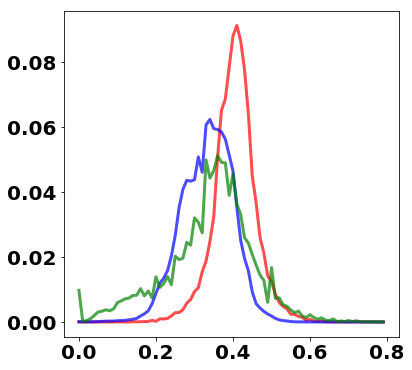

In [39]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(1-gene_at_sum_df['Interval_edge'], gene_at_sum_df['norm_count_AT'], '-', color='r', label = 'genes',  linewidth=3, alpha = 0.7)
ax.plot(1-w_at_sum_df['Interval_edge'], w_at_sum_df['norm_count_AT'], '-', color='b', label = 'windows',  linewidth=3, alpha = 0.7)
ax.plot(1-repeat_at_sum_df['Interval_edge'], repeat_at_sum_df['norm_count_AT'], '-', color='g', label = 'repeats',  linewidth=3, alpha = 0.7)

In [51]:
pst104_genome_fa_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.fa'
pst104_genebed_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.gene.bed'
pst104_repetbed_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/REPET/TE_analysis/Pst_104E_v13_p_ctg.104Ep_DK0911p.REPET.superfamily.sorted.bed'
pst104_window_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/window_analysis/Pst_104E_v12_p_ctg.w1.s200.bed'

In [69]:
pst104_gene_df, pst104_gene_sum_df = AT_content_df(pst104_genebed_fn, pst104_genome_fa_fn, intervals)
pst104_repetbed_df, pst104_repetbed_sum_df = AT_content_df(pst104_repetbed_fn, pst104_genome_fa_fn, intervals)
pst104_window_df, pst104_window_sum_df = AT_content_df(pst104_window_fn, pst104_genome_fa_fn, intervals)

In [72]:
print(1-pst104_repetbed_df['%AT'].mean())
print(1-pst104_gene_df['%AT'].mean())

0.439776837990843
0.4584822291562034


In [73]:
print(1- gene_at_df['%AT'].mean())
print(1- repeat_at_df['%AT'].mean())

0.4100335985065753
0.3441379603560951


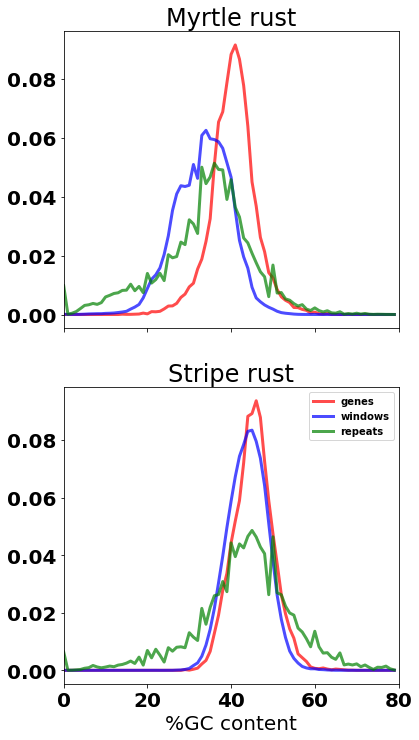

In [84]:
fig, ax = plt.subplots(2, 1, figsize=(6,12), sharex=True)

x_values = (1-gene_at_sum_df['Interval_edge'])*100
ax[0].plot(x_values, gene_at_sum_df['norm_count_AT'], '-', color='r', label = 'genes',  linewidth=3, alpha = 0.7)
ax[0].plot(x_values, w_at_sum_df['norm_count_AT'], '-', color='b', label = 'windows',  linewidth=3, alpha = 0.7)
ax[0].plot(x_values, repeat_at_sum_df['norm_count_AT'], '-', color='g', label = 'repeats',  linewidth=3, alpha = 0.7)
ax[1].plot(x_values,pst104_gene_sum_df['norm_count_AT'], '-', color='r', label = 'genes',  linewidth=3, alpha = 0.7)
ax[1].plot(x_values, pst104_window_sum_df['norm_count_AT'], '-', color='b', label = 'windows',  linewidth=3, alpha = 0.7)
ax[1].plot(x_values, pst104_repetbed_sum_df['norm_count_AT'], '-', color='g', label = 'repeats',  linewidth=3, alpha = 0.7)


ax[1].set_xlim(0,80)
ax[0].set_title('Myrtle rust')

ax[1].set_title('Stripe rust')
ax[1].set_xlabel('%GC content')
plt.legend(loc='best', fontsize = 10)

In [87]:
pst104_genome_fa_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.fa'
pst104_genebed_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.gene.bed'
pst104_oc_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/compositionGC.txt'
pst104_repetbed_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/REPET/TE_analysis/Pst_104E_v13_p_ctg.104Ep_DK0911p.REPET.superfamily.sorted.bed'

In [57]:
pst104_window_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/window_analysis/20191212'

In [55]:
1 - gene_at_df['%AT'].mean()

0.4100335985065753

In [56]:
1 - w_at_df['%AT'].mean()

0.33815799984741546

### Look at Occultor cut

In [88]:
m_oc_df = pd.read_csv(os.path.join(AT_analysis, 'compositionGC.txt'), sep=' ', header=None)
s_oc_df = pd.read_csv(pst104_oc_fn, sep=' ', header=None)

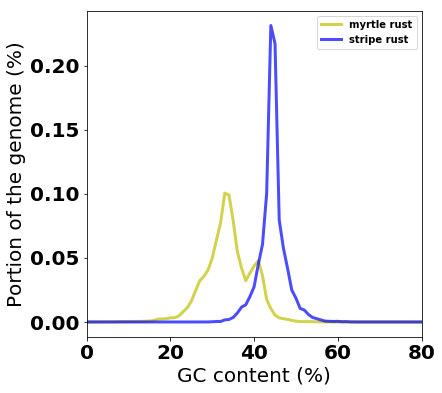

In [89]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(m_oc_df[0], m_oc_df[1], '-', color='y', label = 'myrtle rust',  linewidth=3, alpha = 0.7)
ax.plot(s_oc_df[0], s_oc_df[1], '-', color='b', label = 'stripe rust',  linewidth=3, alpha = 0.7)
ax.set_ylabel('Portion of the genome (%)')
ax.set_xlabel('GC content (%)')
ax.set_xlim(0,80)
plt.legend(loc='best', fontsize = 10)

In [26]:
df = window_AT_dict['w5kb_s1kb']

In [17]:
gene_at_df.head()

,0,1,2,%AT
1,APSI_P001,2416,4010,0.659348
2,APSI_P001,88118,88556,0.527397
3,APSI_P001,129102,131688,0.671307
4,APSI_P001,360883,363449,0.580281
5,APSI_P001,362094,363449,0.547601


In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(gene_at_df['%AT'], bins=10,  alpha=0.5)

(array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   7.00000000e+00,   3.10000000e+01,
          1.14000000e+02,   1.76000000e+02,   3.81000000e+02,
          1.41400000e+03,   3.31100000e+03,   7.25000000e+03,
          1.42780000e+04,   2.34730000e+04,   3.70320000e+04,
          6.91350000e+04,   1.51703000e+05,   2.13660000e+05,
          3.51597000e+05,   4.31729000e+05,   4.45442000e+05,
          4.83785000e+05,   5.06503000e+05,   4.47696000e+05,
          3.71940000e+05,   3.53672000e+05,   3.48173000e+05,
          2.84467000e+05,   1.85398000e+05,   1.31874000e+05,
          9.27200000e+04,   6.34770000e+04,   2.64100000e+04,
          1.79570000e+04,   8.23200000e+03,   5.66100000e+03,
          3.83700000e+03,   2.86800000e+03,   2.36100000e+03,
          1.81900000e+03,   1.03300000e+03,   4.48000000e+02,
        

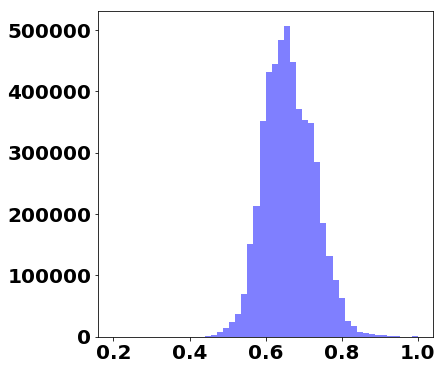

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(df['%AT'], bins=50, color='b', range=(0.2,1.0), alpha=0.5)
#ax.hist(gene_at_df['%AT'], bins=50, color='r', range=(0.2,1.0), alpha=0.5)

In [ ]:
print('hello')

In [54]:
df['%AT'].plot.hist( n=60)

TypeError: Empty 'DataFrame': no numeric data to plot